# How region masks work

These are the regions defiend in the `regions` library. They can be read from DS9 files or created by hand. There are versions in pixel and celestial sky coordinates, but here I will concentrate only on the pixel regions.

In [14]:
from pathlib import Path
import numpy as np
import regions as rg
import seaborn as sns
from matplotlib import pyplot as plt
from mpdaf.obj import Image, Cube

sns.set_context("talk")

## TLDR recommendations

For 2d images that are not too large, then we can just use
1. `reg.to_mask().to_image(image)` which returns a logical mask of the same shape as the image
2. or `reg.to_mask().multiply(image)` which directly applies the multiplication

For 3d cubes, we can use `slices_large` which is the first of two results returned from `reg.to_mask().get_overlap_slices(shape)`. This is the slices into the image dimensions of the cube that extracts the bounding box of the region. Then we can extend that along the spectral axis. For non-rotated rectangular regions, this is enough. But for more general shapes, we can also apply it to the result of `.to_image()`

In [2]:
small_data_path = Path.cwd().parent.parent / "data"
region_file = "ngc346-jesus-muse-pixels.reg"
pixel_regions = rg.Regions.read(small_data_path / region_file)

In [3]:
line_map = Image(str(small_data_path / "ngc346-rgbchan-xxx-8151-sum.fits"))

In [4]:
region_dict = {reg.meta["label"]: reg for reg in pixel_regions}

In [5]:
vmin, vmax = 0.0, 100.0

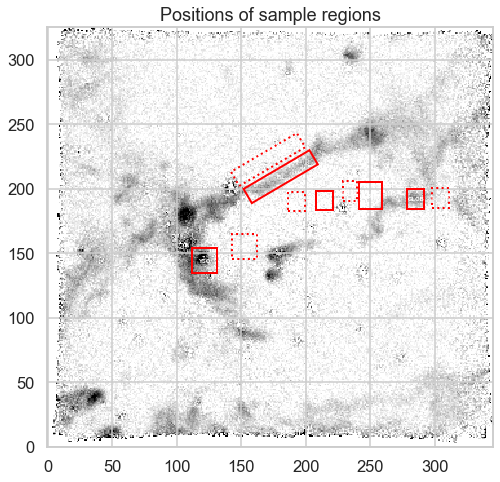

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
line_map.plot(vmin=vmin, vmax=vmax, ax=ax, cmap="gray_r", title="Positions of sample regions")
for label, reg in region_dict.items():
    is_bg = label.endswith(" bg")
    linestyle = "dotted" if is_bg else "solid"
    fontweight = "normal" if is_bg else "bold"
    reg.plot(ax=ax, facecolor='none', edgecolor='red',
             lw=2,
             linestyle=linestyle,
             )
    ax.text(reg.center.x, reg.center.y, label,
            ha="center", va="center", fontsize="xx-small", fontweight=fontweight, color="w")
...;

Look at one particular region in detail and create a region mask object:

In [7]:
region = region_dict["FIL"]
region_mask = region.to_mask()

We can get two sets of slices. The first is the more useful, which is the slices into the full  image array that corresponds to the bounding box of the mask. The second is the same, but into the small mask cutout array, which is only necessary if the mask goes outside of the image.

In [8]:
slices_large, slices_small = region_mask.get_overlap_slices(line_map.data.shape)
slices_large, slices_small

((slice(189, 231, None), slice(152, 210, None)),
 (slice(0, 42, None), slice(0, 58, None)))

We will check that `slices_small` is just the full size of the cutout rectangle in this case:

In [9]:
region_mask.cutout(line_map.data).shape

(42, 58)

Now we will look at the different methods on the mask.

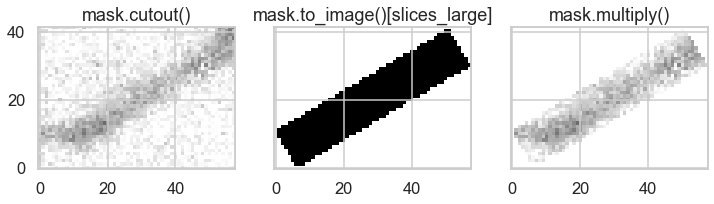

In [10]:
fig, axes = plt.subplots(1, 3, sharex='all', sharey='all',  figsize=(12, 3))
axes[0].imshow(
    region_mask.cutout(line_map.data),
    vmin=vmin, vmax=vmax, origin="lower", cmap="gray_r")
axes[0].set_title("mask.cutout()")
axes[1].imshow(
    region_mask.to_image(line_map.data.shape)[slices_large],
    vmin=0, vmax=1.0, origin="lower", cmap="gray_r")
axes[1].set_title("mask.to_image()[slices_large]")
axes[2].imshow(
    region_mask.multiply(line_map.data),
    vmin=vmin, vmax=vmax, origin="lower", cmap="gray_r")
axes[2].set_title("mask.multiply()")
...;

How to extend this to cubes

In [11]:
(slice(None, None),) + slices_large

(slice(None, None, None), slice(189, 231, None), slice(152, 210, None))

In [16]:
c = Cube(data=np.ones((2, 2, 2)))
c

<Cube(shape=(2, 2, 2), unit='', dtype='float64')>

In [18]:
(c * np.asarray([[1, 0], [0, 0]])).data

masked_array(
  data=[[[1.0, 0.0],
         [0.0, 0.0]],

        [[1.0, 0.0],
         [0.0, 0.0]]],
  mask=[[[False, False],
         [False, False]],

        [[False, False],
         [False, False]]],
  fill_value=1e+20)